# RNN & LSTM

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.compat.v1 as tf1
tf1.disable_v2_behavior()
#tf.compat.v1.enable_eager_execution()
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_visible_devices(devices=gpus[0], device_type='GPU')

Instructions for updating:
non-resource variables are not supported in the long term


## 탄력적으로 GPU 메모리 사용하기
<p>
기본적으로, TensorFlow는 GPU를 쓸 때 거의 대부분의 GPU 메모리를 사용합니다. 이는 디바이스의 메모리 단편화를 방지해 메모리를 효율적으로 사용할 수 있기 때문입니다. 때때로 디바이스에서 사용 가능한 메모리의 일부분만 할당하거나, 실행 과정에서 메모리를 추가로 할당하는 것이 더 나을 수도 있습니다. </p>

<p>
allow_growth 옵션을 이용하여 실행 과정에서 요구되는 만큼의 GPU 메모리만 할당하게 할 수 있습니다. 처음에는 매우 작은 메모리만 할당합니다. 그리고 세션이 실행되면서 더 많은 GPU 메모리가 필요해지면, TensorFlow에서 필요한 메모리 영역을 증가시켜 추가로 할당하게 됩니다. 메모리 할당을 해제하면 메모리 단편화 현상이 발생할 수 있으므로 증가된 메모리는 해제되지 않습니다. 이 옵션을 사용하기 위해서, 다음과 같은 코드로 ConfigProto의 옵션을 설정할 수 있습니다.</p>

In [2]:
# 탄력적으로 GPU memory 사용 방법
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.InteractiveSession(config=config)

## Recurrent Neural Network (RNN)

<p>뉴런의 출력이 다시 입력으로 feedback되는 재귀적인 연결 구조를 갖는 신경망. </p>

<p>MLP는 입력이 출력 방향으로만 활성화되고 은닉 뉴런이 과거의 정보를 기억하지 못한다는 단점이 있습니다. 이러면 **입력이 들어온 문맥을 기억**할 수 없어 시계열 분석 관련 문제에 매우 안 좋은 영향을 끼칩니다.  RNN은 이런 단점을 해결하였습니다. </p>

<p>기존의 DNN(Deep Neural Networks)의 경우 각 layer마다 parameter들이 독립적이었으나, RNN은 이를 공유하고 있습니다. 가중치를 공유한다는 점은 학습해야하는 파라미터 수를 줄이는 데 기여하는 역할도 합니다.</p>

<img src="https://qph.fs.quoracdn.net/main-qimg-f356d404581523148df544daee2220d4">



### RNN의 기본 구조

<ul>
  <li>녹색 박스: hidden state</li>
  <li>빨간색 박스: 인풋</li>
  <li>파란색 박스: 아웃풋 </li>
</ul>

<p>현재 히든 상태 $h_t$는 현재 입력 $x_t$와 직전 시점의 히든 상태 $h_{t-1}$를 받아 갱신됩니다. 현재 히든 상태를 계산할 때는 비선형 activation 함수를 적용합니다. 현재 아웃풋 $y_t$의 경우 현재 히든 $h_t$를 받아 갱신됩니다. RNN이 recurrent 하다고 불리는 이유는 동일한 태스크를 한 시퀀스의 모든 요소마다 적용하고, 출력 결과는 이전의 계산 결과에 영향을 받기 때문입니다. 현재의 출력 결과는 이전 time step의 결과에 영향을 받으며, hidden layer는 일종의 메모리 역할을 하게 됩니다. </p>

<p>이러한 구조는 앞에서 무슨 단어가 나왔는지 안다면 다음에 나올 단어를 예측(prediction)하는 문제를 푸는 데 유용할 것입니다. 이런 문제에는 음성 인식, 필기체 인식, 텍스처 인식이 있습니다. 언어 모델(language model) 은 말뭉치(corpus)를 이용한 기계 번역(machine translation)에도 활용할 수 있습니다. </p>

<img src="http://i.imgur.com/s8nYcww.png" height=300>
<img src="https://i.imgur.com/kpZBDfV.gif" height=300>

### RNN의 다양한 입출력 관계
<img src="http://i.imgur.com/Q8zv6TQ.png" height=300px>

### RNN으로 무엇을 할 수 있을까요?

- 언어 모델링과 텍스트 생성
- 기계 번역
<img src="http://www.wildml.com/wp-content/uploads/2015/09/Screen-Shot-2015-09-17-at-10.39.06-AM-1024x557.png" height=300>
- 음성 인식
- 이미지 캡션 생성
<img src="http://www.wildml.com/wp-content/uploads/2015/09/Screen-Shot-2015-09-17-at-11.44.24-AM.png" height=300>

### 언어 모델링

<p>언어 모델이란 단어의 시퀀스의 확률을 예측하는 모델로서 문장의 확률을 예측, 즉 이전 단어들이 주어졌을 때 다음 단어가 나올 확률을 예측하는 모델을 말합니다 언어 모델은 1. 문장 전체의 확률을 예측하는 일을 하며, 또한 이 일을 하기 위해서 2. 이전 단어들이 주어졌을 때, 다음 단어가 등장할 확률을 예측하는 일도 합니다. 언어 모델이 이 두 가지 확률을 어떻게 예측하며 또한 결국 왜 이 두 가지가 연관되는 문제인지 알아보겠습니다.</p>

#### 문장의 확률 예측
<p>하나의 단어(word)를 w, 단어의 시퀀스인 전체 문장(sentence)을 대문자 W라고 할 때 n개의 w로 구성된 문장 W의 확률은 다음과 같이 표현할 수 있습니다.
$$ P(W) = P(w_1, w_2, w_3, w_4, w_5, ... ,w_n) = \prod_{n=1}^{n}P(w_{n}) $$
</p>

#### 다음 단어 예측
<p>n-1개의 단어가 나열된 상태에서 n번째 단어의 확률을 다음과 같이 표현할 수 있습니다. 
  $$ P(w_n | w_1, ..., w_{n-1}) $$

  전체 단어 시퀀스(문장)의 확률은 모든 단어가 예측되고 나서야 알 수 있으므로 결국 전체 단어 시퀀스의 예측은 다음과 같습니다.
  $$ P(W) = P(w_1, w_2, w_3, w_4, w_5, ... w_n) = \prod_{n=1}^{n}P(w_{n} | w_{1}, ... , w_{n-1}) $$
</p>


### 예제. Hello 배우기
<img src="https://i.imgur.com/rUsJPSD.png">

In [3]:
# 어레이를 처리하기 위한 package
import numpy as np

In [4]:
# hello를 구성하는 문자 
unique = 'helo'

In [5]:
# 'helo'가 '1234'에 맵핑된다고 하였을 때 'ello'는 '1223'
y_data = [1, 2, 2, 3]   
# 'helo'가 '1234'에 맵핑된다고 하고 각각을 one hot encoding으로 바꾸면 아래의 데이터는 hell
x_data = np.array([[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,1,0]], dtype='f')

In [6]:
# 아웃풋이 다시 입력으로 들어가는 Fully-connected RNN - SimpleRNN의 Cell
# 출력 결과(4가지 중에서 선택)
cells  = tf.keras.layers.SimpleRNNCell(4)  
# shape(1, 4), [[0, 0, 0, 0]]
state  = tf.zeros([1, cells.state_size]) 
# layer에 포함될 cell 갯수(4). time_step_size
x_data = tf.split(x_data, 4, axis=0)          
# x_data

### simple_rnn 문법
Creates a recurrent neural network specified by RNNCell  <br>

tf.nn.static_rnn(
    cell,
    inputs,
    initial_state=None,
    dtype=None,
    sequence_length=None,
    scope=None
)


In [7]:
# outputs = [shape(1, 4), shape(1, 4), shape(1, 4), shape(1, 4)]
# state = shape(1, 4)
outputs, state = tf.compat.v1.nn.static_rnn(cells, x_data, state)

Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [8]:
# tf.reshape(tensor, shape, name=None)
# tf.concat(outputs, axis=1) --> shape(1, 16)
logits  = tf.reshape(tf.concat(outputs, axis=1), [1,-1, 4]) # shape(4, 4)
targets = tf.reshape(y_data, [1,-1])                   # shape(4), [1, 2, 2, 3]
weights = tf.ones([1,4])                               # shape(4), [1, 1, 1, 1]

In [14]:
# Weighted cross-entropy loss for a sequence of logits (per example).
loss = tfa.seq2seq.sequence_loss(logits, targets, weights)
cost = tf.reduce_sum(loss)
train_op = tf.compat.v1.train.RMSPropOptimizer(0.01, 0.9).minimize(cost)
init_op = tf.compat.v1.global_variables_initializer()

In [16]:
sess.run(init_op)
for i in range(100):
    sess.run(train_op)
    r0, r1, r2, r3 = sess.run(tf.argmax(logits[0], 1))
    print(r0, r1, r2, r3, ':', unique[r0], unique[r1], unique[r2], unique[r3])

2 1 3 3 : l e o o
2 1 3 3 : l e o o
2 1 3 3 : l e o o
2 1 3 3 : l e o o
2 1 3 3 : l e o o
2 1 3 3 : l e o o
2 1 3 3 : l e o o
2 1 3 3 : l e o o
2 1 3 3 : l e o o
2 1 3 3 : l e o o
2 1 3 3 : l e o o
2 1 3 3 : l e o o
2 1 3 3 : l e o o
2 1 3 3 : l e o o
2 1 3 3 : l e o o
2 1 3 3 : l e o o
2 1 3 3 : l e o o
2 1 3 3 : l e o o
2 1 3 3 : l e o o
2 1 3 3 : l e o o
2 1 3 3 : l e o o
2 1 3 3 : l e o o
2 1 3 3 : l e o o
2 1 3 3 : l e o o
2 1 3 3 : l e o o
2 1 3 3 : l e o o
2 1 3 3 : l e o o
2 1 3 3 : l e o o
2 1 3 3 : l e o o
2 1 3 3 : l e o o
2 1 3 3 : l e o o
2 1 3 3 : l e o o
2 1 3 3 : l e o o
2 1 3 3 : l e o o
2 1 3 3 : l e o o
2 1 3 3 : l e o o
2 1 3 3 : l e o o
2 1 3 3 : l e o o
2 1 3 3 : l e o o
2 1 3 3 : l e o o
2 1 3 3 : l e o o
2 1 3 3 : l e o o
2 1 3 3 : l e o o
2 2 3 3 : l l o o
2 2 3 3 : l l o o
2 2 3 3 : l l o o
2 2 3 3 : l l o o
2 2 2 3 : l l l o
2 2 2 3 : l l l o
2 2 2 3 : l l l o
2 2 2 3 : l l l o
2 2 2 3 : l l l o
2 2 2 3 : l l l o
2 2 2 3 : l l l o
2 2 2 3 : l l l o
2 2 2 3 : 

### RNN에서의 back-propagation: Backpropagation Through Time (BPTT)
<img src="http://www.wildml.com/wp-content/uploads/2015/09/rnn.jpg" height=200>

<p>RNN의 기본 계산 수식.
  $$ \begin{align}
s_t & = \tanh ( U x_t + W s_{t-1} ) \\
\hat{y_t} & = softmax ( V s_t ) \\
\end{align}
$$

  Loss (에러)는 cross entropy로 정의하고, 그 식은 아래와 같습니다.
  $$ \begin{align}
E(y_t, \hat{y_t}) & = -y_t \log{\hat{y_t}} \\
E(y, \hat{y}) & = -\sum_{t}{E_t (y_t, \hat{y_t})} \\
& = -\sum_t -y_t \log \hat{y_t} \\
\end{align} $$

  여기서 $y_t$는 시간 스텝 t에서 실제 단어이고, $\hat{y_t}$ 는 예측값입니다. 보통 전체 시퀀스(문장)를 하나의 학습 데이터(샘플)로 생각하고, 총 에러는 매 시간 스텝(단어)마다의 에러의 총 합으로 계산합니다.
  
  <img src="http://www.wildml.com/wp-content/uploads/2015/10/rnn-bptt1.png" height=300>

원래 목표는 파라미터 U, V, W에 대한 에러의 gradient를 계산해서 optimizer를 이용해 좋은 파라미터 값들을 찾는 것입니다. 에러들을 더하듯이, 매 시간 스텝의 gradient도 하나의 학습 데이터에 대해 모두 더해주면
  $\frac{\partial E}{\partial W} = \sum_{t}{\frac{\partial E_t}{\partial W}}$ 가 됩니다.
  
  이 gradient들을 계산하기 위해선 미분의 chain rule을 사용하는데, 에러에서부터 거꾸로 된 방향으로 계산하는 것으로 결국 backpropagation 알고리즘입니다. E3을 기준으로 설명하면,
  $$ \begin{align}
\frac{\partial E_3}{\partial V} & = \frac{\partial E_3}{\partial \hat{y_3}} \frac{\partial \hat{y_3}}{\partial V} \\
& = \frac{\partial E_3}{\partial \hat{y_3}} \frac{\partial \hat{y_3}}{\partial z_3} \frac{\partial z_3}{\partial V} \\
& = (\hat{y_3} - y_3) \otimes s_3 \\
\end{align} $$
  
</p>


<p>위 식에서, $z_3=Vs_3$이고, $\otimes$는 두 벡터의 외적입니다. 핵심 포인트는 $\frac{\partial E_3}{\partial V}$가 현재 시간 스텝의 $\hat{y_3}, y_3, s_3$에만 의존한다는 점입니다. 이 세 값을 갖고 있다면 V에 대한 gradient를 계산하는 것은 단순한 행렬곱이 되게 됩니다. 

그러나,  $\frac{\partial E_3}{\partial W}$에 대해서는 (U에 대해서도) 상황이 조금 다른데, 이를 살펴보기 위해 위에서처럼 chain rule을 전개해 보면
$$ \frac{\partial E_3}{\partial W} = \frac{\partial E_3}{\partial \hat{y_3}} \frac{\partial \hat{y_3}}{\partial s_3} \frac{\partial s_3}{\partial W} $$
  
  여기서 $s_t = \tanh ( U x_t + W s_{t-1} )$ 는 $s_2$에 의존하고, $s_2$는 $W$와 $s_1$에 의존해서 chain rule이 계속 이어집니다. 따라서, W에 대한 미분을 하기 위해서는 s2를 단순히 상수로 취급하면 안되고 다시 chain rule을 적용한다면 아래 식을 얻을 수 있습니다.
  $$ \frac{\partial E_3}{\partial W} = \sum_{k=0}^{3}{\frac{\partial E_3}{\partial \hat{y_3}} \frac{\partial \hat{y_3}}{\partial s_3} \frac{\partial s_3}{\partial s_k} \frac{\partial s_k}{\partial W}} $$
  
  
  각 시간 스텝이 gradient에 기여하는 것을 전부 더해줍니다. 즉, W는 현재 처리중인 출력 부분까지의 모든 시간 스텝에서 사용되기 때문에, t=3부터 t=0까지 gradient들을 전부 backpropagate해 주어야 합니다. <br>
<img src="http://www.wildml.com/wp-content/uploads/2015/10/rnn-bptt-with-gradients.png" height=300>
</p>

<p>이 과정은 DNN의 backpropagation 알고리즘과 똑같은 것을 알 수 있습니다. 중요한 차이점은 매 시간 스텝마다 W에 대한 gradient를 더해준다는 점입니다. 기존의 신경망 구조에서는 layer별로 파라미터를 공유하지 않기 때문에 계산 결과들을 서로 더해줄 필요가 없었습니다.
</p>

#### softmax derivative 
<img src="https://i.imgur.com/cLsZ4Tb.png" height=400>

### RNN의 vanishing gradient 문제
<p> RNN은 긴 시퀀스를 처리하는데 (long-range dependency를 처리하는데) 한계가 있습니다. 즉, 주요 단어들 사이에 여러 시간 스텝이 지났다면 잘 기억하지 못 할 수 있습니다. 이는 보통 문장의 의미를 파악하는데 있어서 가까이 있지 않은 단어들이 밀접한 관련이 있을 수도 있기 때문에 문제가 됩니다. </p>

<p>예로, "The man who wore a wig on his head went inside."라는 문장을 보면, 이 문장은 "man"이 "inside"로 가는 것에 대한 문장이지 "wig(가발)"에 대한 것이 아닙니다. 그러나 기본 RNN 모델은 남자보다 가발에 대한 정보를 더 잘 기억할 가능성이 높은데, 왜 그런지 이해하기 위해 위에서 계산한 gradient 식을 자세히 살펴보도록 하겠습니다. </p>

<p>
$$ \frac{\partial E_3}{\partial W} = \sum_{k=0}^{3}{\frac{\partial E_3}{\partial \hat{y_3}} \frac{\partial \hat{y_3}}{\partial s_3} \frac{\partial s_3}{\partial s_k} \frac{\partial s_k}{\partial W}} $$

  이 식에서 주목할 점은 $\frac{\partial s_3}{\partial s_k}$도 chain rule을 내포하고 있어, $\frac{\partial s_3}{\partial s_1} = \frac{\partial s_3}{\partial s_2} \frac{\partial s_2}{\partial s_1}$ 입니다. 또 벡터를 벡터로 미분하고 있어 결과는 행렬(Jacobian matrix)가 나오게 됩니다. 위의 gradient 식을 다시 쓰면,
  
  $$\frac{\partial E_3}{\partial W} = \sum_{k=0}^{3}{\frac{\partial E_3}{\partial \hat{y_3}} \frac{\partial \hat{y_3}}{\partial s_3} \left( \prod_{j=k+1}^{3}{\frac{\partial s_j}{\partial s_{j-1}}} \right) \frac{\partial s_k}{\partial W}}$$

  위 자코비안 행렬의 2-norm (절대값) 값의 최대값이 1이라는 것이 증명되었습니다. (http://proceedings.mlr.press/v28/pascanu13.pdf 참고). 현재 사용하고 있는 activation 함수인 tanh(또는 sigmoid)는 모든 값을 -1부터 1까지로 매핑시켜주고, 미분값은 최대 1로 (sigmoid의 경우 1/4) 정해지기 때문이라고 생각할 수 있습니다. 
</p>

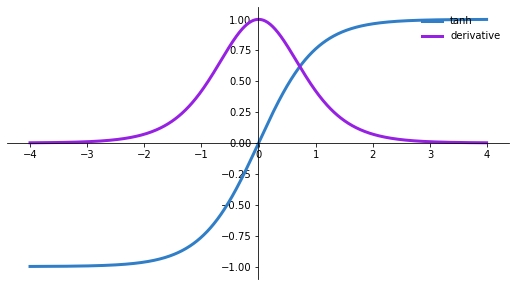

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def tanh(z):
    ez = np.exp(z)
    enz = np.exp(-z)
    return (ez - enz)/ (ez + enz)

# 플랏에 그릴 포인트를 계산합니다. 
z = np.arange(-4., 4., 0.01)
a = tanh(z)
dz = 1 - a**2

# 플랏을 정의합니다. 
fig, ax = plt.subplots(figsize=(9, 5))
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# 플랏에 포인트를 그립니다. 
ax.plot(z,a, color="#307EC7", linewidth=3, label="tanh")
ax.plot(z,dz, color="#9621E2", linewidth=3, label="derivative")
ax.legend(loc="upper right", frameon=False)
fig.show()



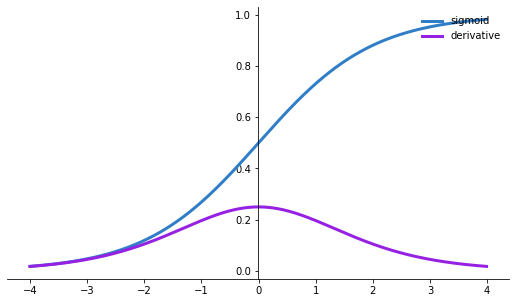

In [18]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

# 플랏에 그릴 포인트를 계산합니다. 
z = np.arange(-4., 4., 0.01)
a = sigmoid(z)
dz = (np.exp(-z))/np.power((1+np.exp(-z)), 2) 

# 플랏을 정의합니다. 
fig, ax = plt.subplots(figsize=(9, 5))
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# 플랏에 포인트를 그립니다. 
ax.plot(z,a, color="#307EC7", linewidth=3, label="sigmoid")
ax.plot(z,dz, color="#9621E2", linewidth=3, label="derivative")
ax.legend(loc="upper right", frameon=False)
fig.show()

<p>tanh 함수와 sigmoid 함수는 양쪽 끝에서 미분값이 0으로 수렴하는 것을 관찰 할 수 있습니다. 이 현상이 발생할 때, 그 뉴런이 포화되었다고 말하는데, 이런 뉴런들은 gradient가 거의 0이기 때문에 곱해지는 이전 layer의 gradient들도 0으로 수렴하게 만듭니다. </p>

<p>따라서, 행렬에 작은 값들이 들어있고 여러 (t-k번) 행렬곱이 이루어지면 gradient는 지수 함수로 감소하고, 시간 스텝 몇 번만 지나도 사라져 버리게 됩니다. (vanish!). 시퀀스에서 여러 시간 스텝이 떨어진 곳에서는 gradient가 전달되지 못하고, 먼 과거의 상태(state)는 현재 스텝의 학습에 아무 도움이 되지 못하게 되어 long-range dependency를 제대로 배우지 못하게 됩니다. Vanishing gradient 문제는 RNN에서만 나타나는 것이 아니라 DNN에서도 마찬가지로 발생하지만, RNN은 보통 시간 스텝 횟수만큼 매우 깊은 구조이기 때문에 이 문제가 훨씬 더 잘 나타나게 됩니다. </p>


<p>Gradient 계산을 보면, 자코비안 행렬 안의 값들이 크다면 activation 함수와 네트워크 파라미터 값에 따라 gradient가 사라지는게 아니라 지수 함수로 증가하는 경우도 상상해 볼 수 있습니다. 이러한 문제를 exploding gradient라고 부릅니다. </p>


<img src="https://i.imgur.com/oun1fih.png" height=300 >

<p>Vanishing gradient 문제가 더 많은 관심을 받은 이유는 두 가지인데, 하나는 exploding gradient 문제는 쉽게 알아차릴 수 있다는 점입니다. Gradient 값들이 너무 크면 NaN (not a number)이 될 것이고 프로그램이 죽을 것 입니다. 두 번째는, gradient 값이 너무 크다면 미리 정해준 적당한 값으로 잘라버리는 방법이 매우 쉽고 효율적으로 이 문제를 해결하기 때문입니다. 반면 Vanishing gradient 문제는 언제 발생하는지 바로 확인하기가 힘들고 간단한 해결법이 없기 때문에 더 큰 문제입니다. 
</p>
  
<p>다행히도, 이 문제를 어느 정도 해결할 수 있는 몇 가지 방법이 있습니다. W 행렬을 적당히 좋은 값으로 잘 초기화 해준다면 vanishing gradient의 영향을 줄일 수 있고, regularization을 잘 정해줘도 비슷한 효과를 볼 수 있습니다. 더 보편적으로 사용되는 방법은 tanh나 sigmoid activation 함수 말고 ReLU를 사용하는 것 입니다. </p>

<p>ReLU는 미분값의 최대치가 1로 정해져있지 않기 때문에 gradient 값이 없어져버리는 일이 크게 줄어듭니다. 이보다 더 인기있는 해결책은 Long Short-Term Memory (LSTM)이나 Gated Recurrent Unit (GRU) 구조를 사용하는 방법입니다. LSTM은 1997년에 처음 제안되었고, 현재 자연어처리 분야에서 가장 널리 사용되는 모델 중 하나이며, GRU는 2014년에 처음 나왔고, LSTM을 간략화한 버전입니다. 두 RNN의 변형 구조 모두 vanishing gradient 문제 해결을 위해 디자인되었고, 효과적으로 긴 시퀀스를 처리할 수 있다는 것이 보여졌습니다. </p>

### 예제. RNN을 이용한 텍스트 생성

<p>
 Andrej Karpathy의 Referential Neural Networks의 The Unreasonable Effectiveness에서 셰익스피어가 쓴 글을 데이터 셋으로 이용하겠습니다. 문자 시퀀스 ( "Shakespear")가 주어지면 시퀀스의 다음 문자 ( "e")를 예측하기 위해 모델을 훈련시킵니다. 모델을 반복적으로 호출하여 더 긴 텍스트 시퀀스를 생성 할 수 있습니다.</p>
 
 <p>
이 튜토리얼에는 tf.keras와 eager excetuttion을 사용하여 구현하도록 하겠습니다. 일반적인 tensorflow의 연산이 나중에 실행하기 위해 계산 그래프를 만드는 반면, eager execution은 그래프를 작성하지 않고 즉시 평가하여 구체적인 값을 반환합니다. 이를 통해 TensorFlow 및 디버그 모델을 쉽게 시작할 수 있습니다. *RNN_text_gernation 노트북 참고* </p>

